# Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
import pickle as pkl
from tqdm import tqdm
import os
import time
from collections import defaultdict
from scipy import stats
from itertools import permutations, product
from numpy.linalg import norm
import seaborn as sns
sns.set(style="darkgrid")
pd.set_option("display.precision", 4)

# Import results

In [7]:
algo_names = ["UserKNN",
              "ItemKNN", 
              "UserKNN with means", 
              "BPR",
              "MF",
              "PMF",
              "NMF",
              "WMF",
              "HPF",
              "NeuMF",
              "VAECF"
              ] # in the order that they are in the model list

In [2]:
results_location = "data/results/"

In [6]:
music_eva_two = pd.read_csv(results_location+"df_item_dist_cornac_music_eva_two.csv", index_col=0)

# Calculate correlation

In [20]:
music_eva_two_corr = pd.DataFrame(columns=["eva_two"], index = algo_names).fillna(0).copy()

In [21]:
music_eva_two_corr.head()

,eva_two
UserKNN,0
ItemKNN,0
UserKNN with means,0
BPR,0
MF,0


In [28]:
profile_pop = music_eva_two["count"]
i=0
for index, row in music_eva_two_corr.iterrows():
    algorithm=algo_names[i]
    rec_pop = music_eva_two[algorithm]
    correlation, _ = stats.pearsonr(profile_pop, rec_pop)
    music_eva_two_corr.loc[algorithm, "eva_two"] = correlation
    i+=1

In [29]:
music_eva_two_corr

,eva_two
UserKNN,0.6586
ItemKNN,0.8881
UserKNN with means,0.6732
BPR,0.8192
MF,0.9039
PMF,0.6223
NMF,0.7565
WMF,0.8191
HPF,0.8390
NeuMF,0.8385


In [36]:
algo_names

['UserKNN',
 'ItemKNN',
 'UserKNN with means',
 'BPR',
 'MF',
 'PMF',
 'NMF',
 'WMF',
 'HPF',
 'NeuMF',
 'VAECF']

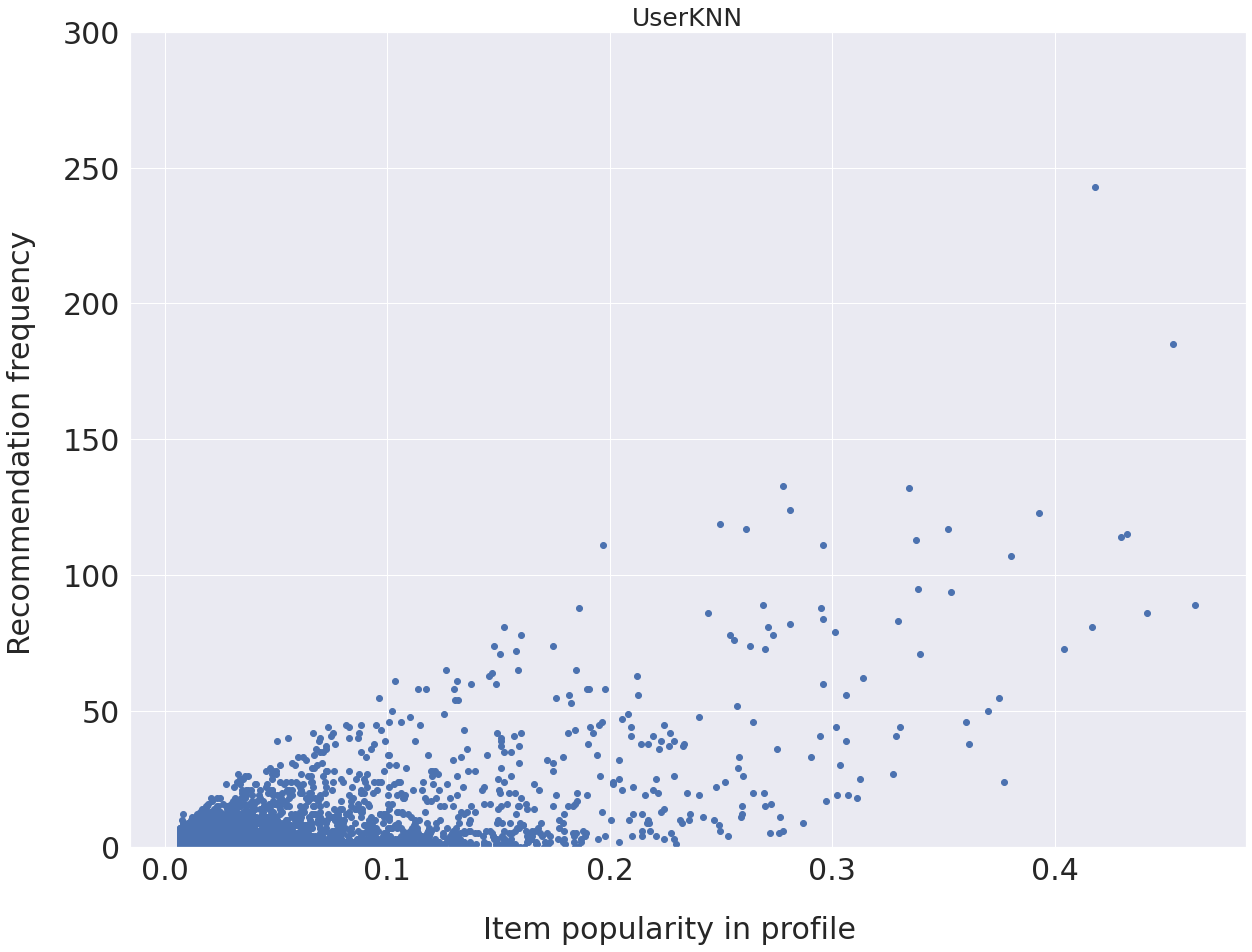

In [66]:
select_algo_names = ["UserKNN"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)

fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
i = 0  
for algo in select_algo_names:
    profile_pop = music_eva_two["count"]
    alg_pop = music_eva_two[algo]
    correlation, _ = stats.pearsonr(profile_pop, alg_pop)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(profile_pop, alg_pop, "o")
    ax.set_ylim(0,300)
    ax.set_title(algo, fontsize='25')
    
    plt.savefig("graphs/"+algo+"_sampled_data_results.png")
    plt.show()

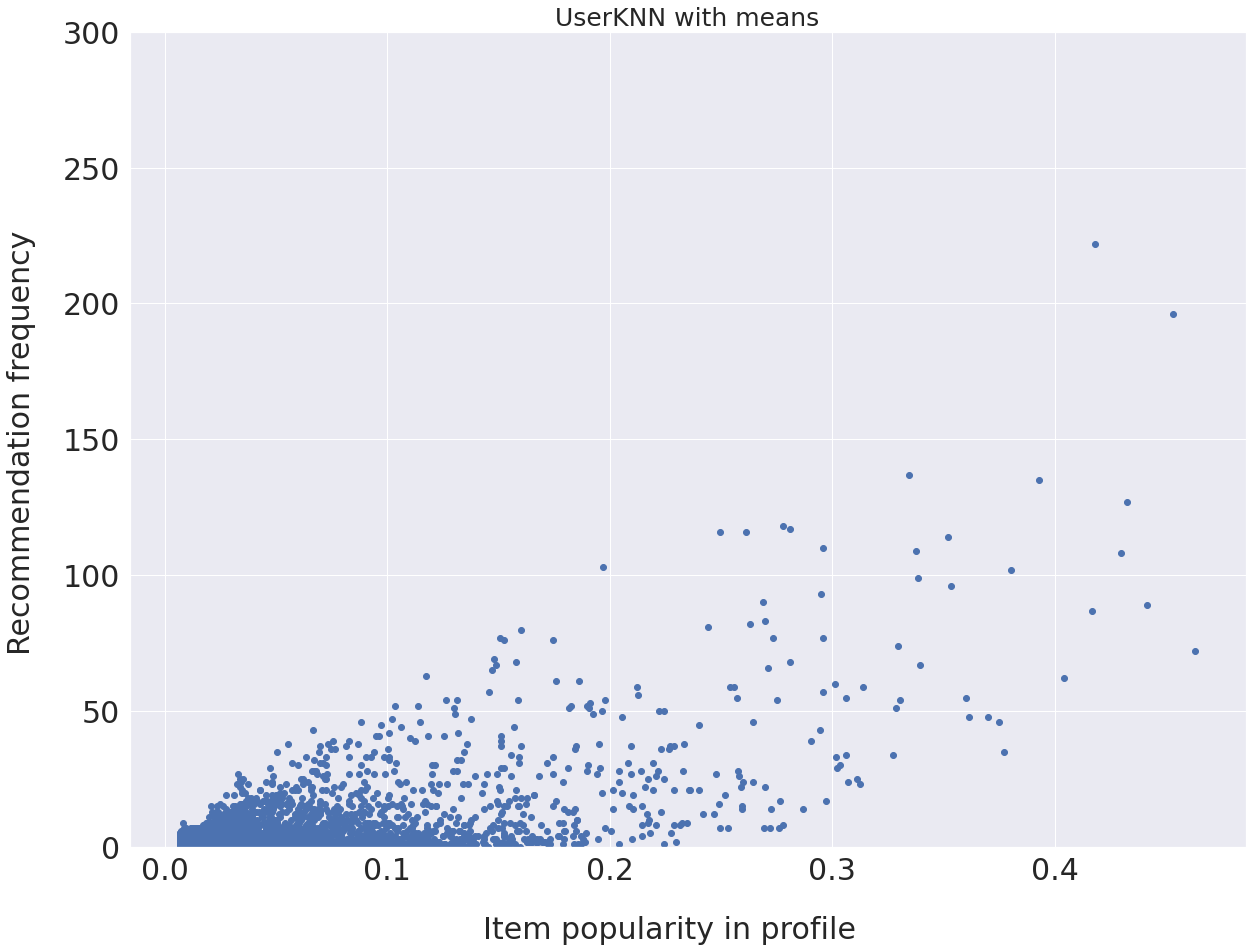

In [67]:
select_algo_names = ["UserKNN with means"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)

fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
i = 0  
for algo in select_algo_names:
    profile_pop = music_eva_two["count"]
    alg_pop = music_eva_two[algo]
    correlation, _ = stats.pearsonr(profile_pop, alg_pop)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(profile_pop, alg_pop, "o")
    ax.set_ylim(0,300)
    ax.set_title(algo, fontsize='25')
    
    plt.savefig("graphs/"+algo+"_sampled_data_results.png")
    plt.show()

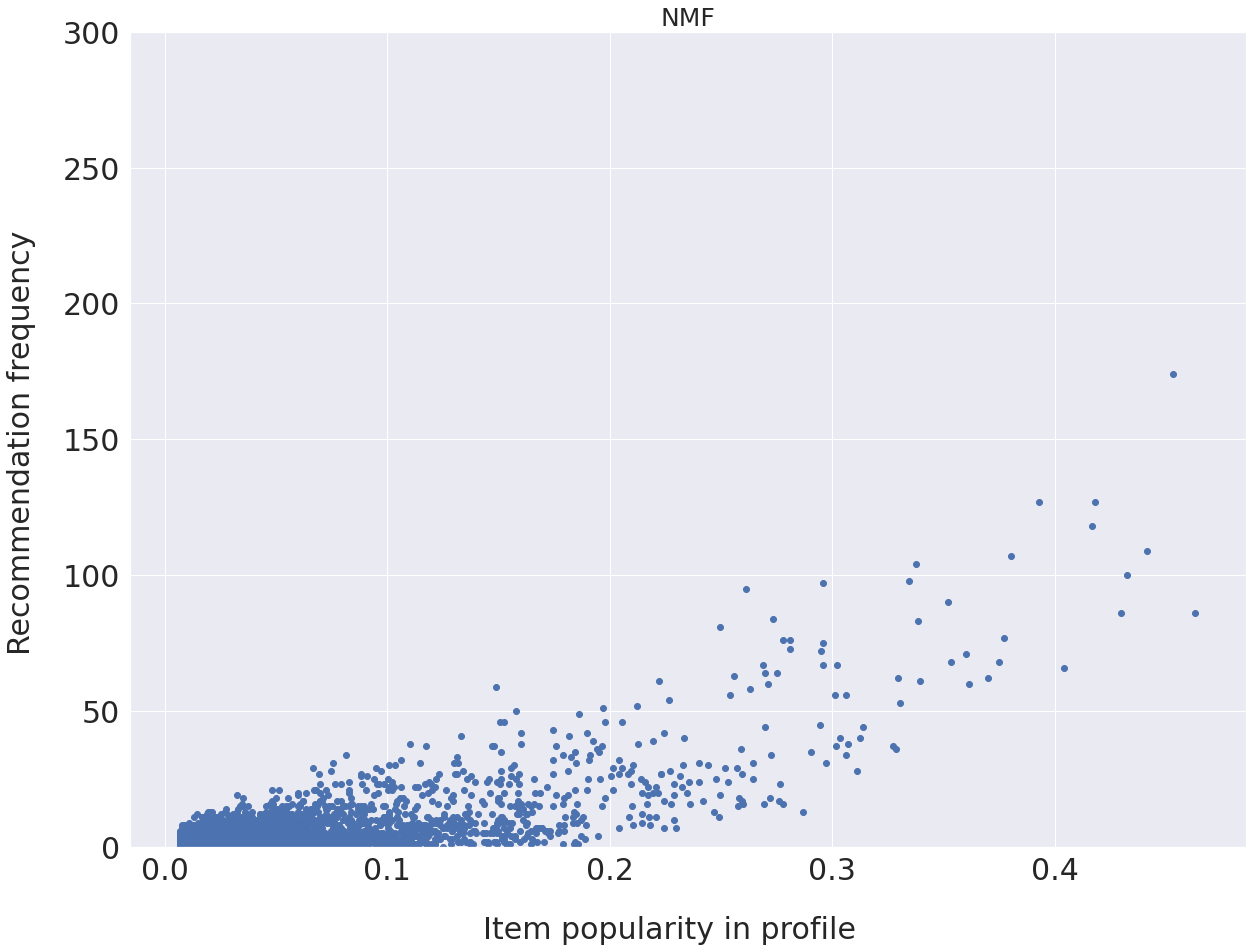

In [68]:
select_algo_names = ["NMF"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)

fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
i = 0  
for algo in select_algo_names:
    profile_pop = music_eva_two["count"]
    alg_pop = music_eva_two[algo]
    correlation, _ = stats.pearsonr(profile_pop, alg_pop)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(profile_pop, alg_pop, "o")
    ax.set_ylim(0,300)
    ax.set_title(algo, fontsize='25')
    
    plt.savefig("graphs/"+algo+"_sampled_data_results.png")
    plt.show()